# Improving Generalization through Active Learning
Original paper: https://link.springer.com/article/10.1007/BF00993277

- This will show a visualization example of defining a concept class and implementing selective sampling to reduce the region of uncertainty.
- For simplicity, the paper demonstrates an example using a two-dimensional space and represents the concept class as a rectangle.

## Setup and Concept Definition

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# define the rectangular bounds for our concept class
concept_bounds = {'x_min': 0.35, 'x_max': 0.65, 'y_min': 0.25, 'y_max': 0.75}

# define the region of uncertainty around the concept class
region_of_uncertainty = [
    {'x_min': 0.3, 'x_max': 0.7, 'y_min': 0.2, 'y_max': 0.6},
    {'x_min': 0.2, 'x_max': 0.6, 'y_min': 0.5, 'y_max': 0.8},
    {'x_min': 0.4, 'x_max': 0.8, 'y_min': 0.4, 'y_max': 0.9},
]

# define points outside any of these regions
outside_points = [
    {'x': 0.1, 'y': 0.1},
    {'x': 0.9, 'y': 0.9},
    {'x': 0.1, 'y': 0.9},
    {'x': 0.9, 'y': 0.1},
    {'x': 0.3, 'y': 0.9},
    {'x': 0.25, 'y': 0.4},
]

# define points inside the concept bounds
inside_points = [
    {'x': 0.4, 'y': 0.3},
    {'x': 0.5, 'y': 0.7},
    {'x': 0.45, 'y': 0.6},
    {'x': 0.6, 'y': 0.35},
]

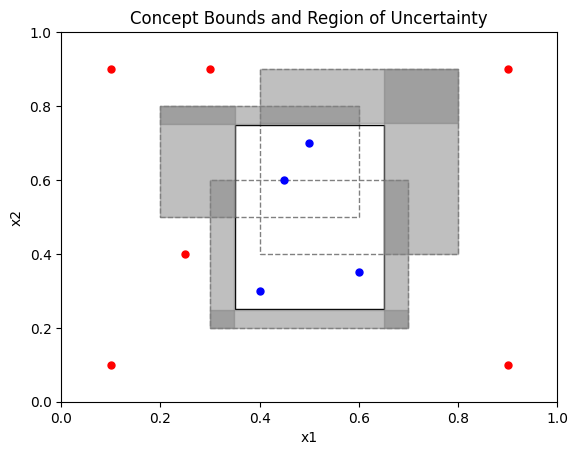

In [5]:
# plot concept bounds and region of uncertainty together
fig, ax = plt.subplots()

for bounds in region_of_uncertainty:
    ax.add_patch(plt.Rectangle((bounds['x_min'], bounds['y_min']),
                               bounds['x_max'] - bounds['x_min'],
                               bounds['y_max'] - bounds['y_min'],
                               fill=False, linestyle='--', color='gray'))
    
ax.add_patch(plt.Rectangle((concept_bounds['x_min'], concept_bounds['y_min']),
                           concept_bounds['x_max'] - concept_bounds['x_min'],
                           concept_bounds['y_max'] - concept_bounds['y_min'],
                           fill=False, color='black'))

# shade regions that are not overlapping with concept bounds rectangle
for bounds in region_of_uncertainty:
    x = np.linspace(bounds['x_min'], bounds['x_max'], 100)
    y1 = np.full_like(x, bounds['y_min'])
    y2 = np.full_like(x, bounds['y_max'])
    plt.fill_between(x, y1, y2, where=(x < concept_bounds['x_min']) | (x > concept_bounds['x_max']), color='gray', alpha=0.5)

    y = np.linspace(bounds['y_min'], bounds['y_max'], 100)
    x1 = np.full_like(y, bounds['x_min'])
    x2 = np.full_like(y, bounds['x_max'])
    plt.fill_betweenx(y, x1, x2, where=(y < concept_bounds['y_min']) | (y > concept_bounds['y_max']), color='gray', alpha=0.5)
    
# plot outside points as the number 0
for point in outside_points:
    plt.plot(point['x'], point['y'], 'ro', markersize=5)
    
# plot inside points as 1
for point in inside_points:
    plt.plot(point['x'], point['y'], 'bo', markersize=5)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Concept Bounds and Region of Uncertainty')
plt.show()

In [6]:
# calculate the total area of the region of uncertainty
total_area = 0
for bounds in region_of_uncertainty:
    total_area += (bounds['x_max'] - bounds['x_min']) * (bounds['y_max'] - bounds['y_min'])

# subtract the area of the concept bounds
concept_area = (concept_bounds['x_max'] - concept_bounds['x_min']) * (concept_bounds['y_max'] - concept_bounds['y_min'])
total_area -= concept_area
print(f'The probability that a new, random point will reduce our uncertainty: {total_area:.2f}')

The probability that a new, random point will reduce our uncertainty: 0.33


## Compare Random Sampling vs Selective Sampling

In [7]:
# check if point is inside a shaded region but outside the concept bounds
def is_in_region(point, region):
    return (point[0] >= region['x_min'] and point[0] <= region['x_max'] and
            point[1] >= region['y_min'] and point[1] <= region['y_max'])

# change bounds of concept bounds if point is inside region of interest
def update_bounds(point, bounds, l = 0.01):
    
    # find the distance between the point and the closest concept bounds and multiply by a l
    dx = l * min(abs(point[0] - bounds['x_min']), abs(point[0] - bounds['x_max']))
    dy = l * min(abs(point[1] - bounds['y_min']), abs(point[1] - bounds['y_max']))

    # Update the concept bounds
    bounds['x_min'] -= dx
    bounds['x_max'] += dx
    bounds['y_min'] -= dy
    bounds['y_max'] += dy
    
    return bounds

In [67]:
# plotting function to plot concept bounds, region of uncertainty and classified points
def plot_classification(concept_bounds, region_of_uncertainty, classified_points, unclassified_points, inside_points, outside_points):
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot the concept bounds
    x_min = concept_bounds['x_min']
    x_max = concept_bounds['x_max']
    y_min = concept_bounds['y_min']
    y_max = concept_bounds['y_max']
    ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'g-')
    
    # Plot the region of uncertainty
    for region in region_of_uncertainty:
        x_min = region['x_min']
        x_max = region['x_max']
        y_min = region['y_min']
        y_max = region['y_max']
        ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'b--')
    
    # Plot the classified points as blue circles
    for point in classified_points:
        x = point[0]
        y = point[1]
        ax.plot(x, y, 'bo', markersize=5)
    # Plot the inside points as blue cirecles
    for point in inside_points:
        x = point['x']
        y = point['y']
        ax.plot(x, y, 'bo', markersize=5)
        
    # Plot the unclassified points as red circles
    for point in unclassified_points:
        x = point[0]
        y = point[1]
        ax.plot(x, y, 'ro', markersize=5)
    # Plot the outside points as red circles
    for point in outside_points:
        x = point['x']
        y = point['y']
        ax.plot(x, y, 'ro', markersize=5)
    
    # Set the axis labels and title
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Classification Plot')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()


### Selective Sampling

In [75]:
def sample_from_distribution(num_samples=300):
    return np.random.rand(num_samples, 2)

# generate samples from the distribution
concept_bounds_copy = {'x_min': 0.35, 'x_max': 0.65, 'y_min': 0.25, 'y_max': 0.75}
samples = sample_from_distribution(num_samples = 1000)
classified_points = []
unclassified_points = []

# loop through each sample, classify the sample and update the bounds if needed
for sample in samples:
    for i, bounds in enumerate(region_of_uncertainty):
        
        # check if inside shaded region and concept bounds
        if is_in_region(sample, bounds) or is_in_region(sample, concept_bounds_copy):
            # classify point for plotting purposes
            classified_points.append(sample)
            
            # update concept bounds if inside shaded region but outside concept bounds
            if not is_in_region(sample, concept_bounds_copy):
                concept_bounds_copy = update_bounds(sample, concept_bounds_copy)
    
# for points that are not classified, classify them as unclassified
for sample in samples:
    if tuple(sample) not in map(tuple, classified_points):
        unclassified_points.append(sample)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


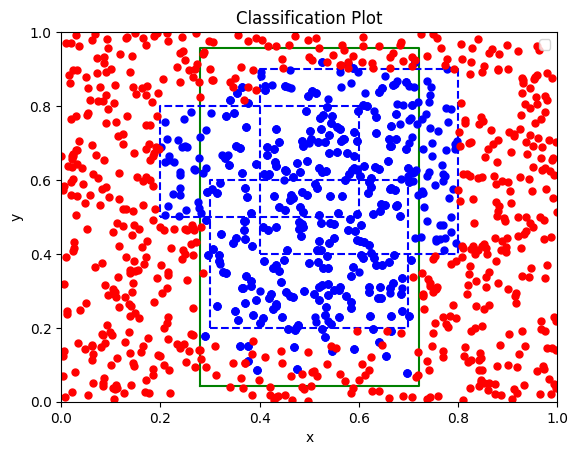

In [76]:
plot_classification(concept_bounds_copy, region_of_uncertainty, classified_points, unclassified_points, inside_points, outside_points)

### Random Sampling

In [85]:
# generate samples from the distribution
concept_bounds_copy = {'x_min': 0.35, 'x_max': 0.65, 'y_min': 0.25, 'y_max': 0.75}
samples = sample_from_distribution(num_samples = 1000)
classified_points = []
unclassified_points = []
region_of_uncertainty_random = []

# loop through each sample, classify the sample and update the bounds if needed
for sample in samples:
    
    # classify point and update concept bounds
    if is_in_region(sample, concept_bounds_copy):
        classified_points.append(sample)
    concept_bounds_copy = update_bounds(sample, concept_bounds_copy)
    
# for points that are not classified, classify them as unclassified
for sample in samples:
    if tuple(sample) not in map(tuple, classified_points):
        unclassified_points.append(sample)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


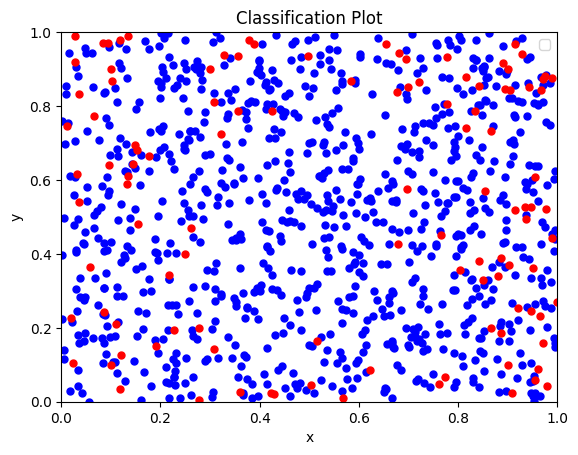

In [86]:
plot_classification(concept_bounds_copy, region_of_uncertainty_random, classified_points, unclassified_points, inside_points, outside_points)